In [1]:
# 匯入我們需要的函式庫
import torch
import torchvision
import torchvision.transforms as transforms

# --- 步驟 1: 準備與載入資料 ---

# 定義一個轉換流程 (transform)
# 1. torchvision.transforms.ToTensor() 會做兩件事：
#    a. 將 PIL Image 或 numpy.ndarray 轉換成 PyTorch 的 Tensor 格式。
#    b. 將圖片的像素值從 [0, 255] 的整數範圍，縮放到 [0.0, 1.0] 的浮點數範圍。
transform = transforms.ToTensor()

# 下載並載入 MNIST 訓練資料集
# root='./data': 指定資料要下載到哪個資料夾
# train=True: 表示我們要的是「訓練集」
# download=True: 如果 './data' 資料夾內沒有資料，就自動從網路上下載
# transform=transform: 將每一張圖片都套用我們上面定義的轉換流程
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# 看看資料集有多大
print(f"訓練資料集的總筆數: {len(train_dataset)}")
print(f"資料集的類別: {train_dataset.classes}")

訓練資料集的總筆數: 60000
資料集的類別: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


影像 Tensor 的形狀: torch.Size([1, 28, 28])
對應的標籤: 5


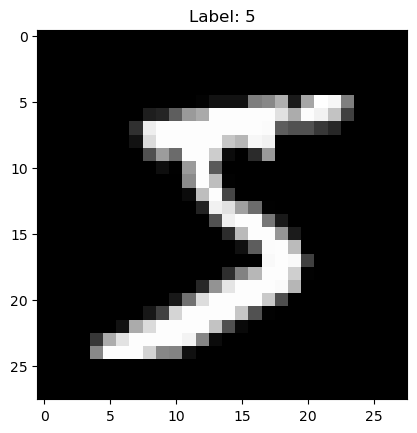

In [2]:
import matplotlib.pyplot as plt

# --- 步驟 2: 探索資料 ---

# 使用索引 (indexing) 取出第一筆資料
# train_dataset[0] 會回傳一個包含兩項內容的元組 (tuple)
# 第一項是影像的 Tensor，第二項是它的標籤
image, label = train_dataset[0]

# --- 來深入看看這個 "image" 是什麼 ---
# .shape 屬性可以告訴我們 Tensor 的「形狀」
print(f"影像 Tensor 的形狀: {image.shape}")
print(f"對應的標籤: {label}")

# --- 視覺化影像 ---
# plt.imshow() 用於顯示圖片
# image.squeeze() 的作用是移除維度為 1 的維度
# 原始形狀是 [1, 28, 28]，為了讓 matplotlib 能畫出灰階圖，需要變成 [28, 28]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Label: {label}')
plt.show()

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# --- 步驟 3: 建立 CNN 模型 ---

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 定義第一組卷積層 + 池化層
        # nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        # in_channels=1: 輸入的圖片是單一灰階頻道
        # out_channels=10: 我們希望有 10 個濾波器，產生 10 個特徵圖
        # kernel_size=5: 每個濾波器的大小是 5x5
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # nn.MaxPool2d(kernel_size=2): 用一個 2x2 的窗口做最大池化，可以將圖片尺寸減半
        self.pool = nn.MaxPool2d(kernel_size=2)

        # 定義第二組卷積層 + 池化層
        # in_channels=10: 輸入來自上一層產生的 10 個特徵圖
        # out_channels=20: 我們希望再產生 20 個更複雜的特徵圖
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        # 定義兩個全連接層 (Fully Connected Layers)
        # 為什麼是 320？ 經過兩次池化，圖片大小從 28x28 -> 14x14 -> 7x7，再去掉邊緣 -> 4x4
        # 所以有 20 個 4x4 的特徵圖，總共有 20 * 4 * 4 = 320 個特徵值
        self.fc1 = nn.Linear(320, 50)
        # 最後的輸出需要是 10 個數字 (對應 0-9)，所以 out_features=10
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # 定義資料前向傳播的流程
        # x 的形狀: [batch_size, 1, 28, 28]

        # 通過第一組 conv -> relu -> pool
        x = self.pool(F.relu(self.conv1(x)))
        # x 的形狀: [batch_size, 10, 12, 12]

        # 通過第二組 conv -> relu -> pool
        x = self.pool(F.relu(self.conv2(x)))
        # x 的形狀: [batch_size, 20, 4, 4]

        # 將多維的特徵圖攤平成一維向量
        x = x.view(-1, 320)
        # x 的形狀: [batch_size, 320]

        # 通過第一個全連接層
        x = F.relu(self.fc1(x))
        # x 的形狀: [batch_size, 50]

        # 通過第二個全連接層得到最終輸出
        x = self.fc2(x)
        # x 的形狀: [batch_size, 10]
        return x

# 建立一個模型的實例
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [4]:
from torch.utils.data import DataLoader

# --- 步驟 4: 設定訓練迴圈 ---

# 建立 DataLoader
# batch_size=64: 每次從資料集中取出 64 張圖片來訓練
# shuffle=True: 每個 epoch 開始前都將資料集打亂，增加隨機性
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# 重新建立一個乾淨的模型實例
model = SimpleCNN()

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # lr 是學習率 (learning rate)

# --- 開始訓練 ---
num_epochs = 3 # 決定要將整個資料集看過幾遍

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 1. 前向傳播 (Forward pass)
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 2. 反向傳播與優化 (Backward and optimize)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 每 100 個批次，印出一次目前的 loss
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print('訓練完成!')

Epoch [1/3], Step [100/938], Loss: 0.7415
Epoch [1/3], Step [200/938], Loss: 0.3207
Epoch [1/3], Step [300/938], Loss: 0.2610
Epoch [1/3], Step [400/938], Loss: 0.1120
Epoch [1/3], Step [500/938], Loss: 0.1434
Epoch [1/3], Step [600/938], Loss: 0.2504
Epoch [1/3], Step [700/938], Loss: 0.1199
Epoch [1/3], Step [800/938], Loss: 0.0332
Epoch [1/3], Step [900/938], Loss: 0.0668
Epoch [2/3], Step [100/938], Loss: 0.0554
Epoch [2/3], Step [200/938], Loss: 0.0594
Epoch [2/3], Step [300/938], Loss: 0.1158
Epoch [2/3], Step [400/938], Loss: 0.0607
Epoch [2/3], Step [500/938], Loss: 0.0327
Epoch [2/3], Step [600/938], Loss: 0.0568
Epoch [2/3], Step [700/938], Loss: 0.0644
Epoch [2/3], Step [800/938], Loss: 0.1114
Epoch [2/3], Step [900/938], Loss: 0.0198
Epoch [3/3], Step [100/938], Loss: 0.0361
Epoch [3/3], Step [200/938], Loss: 0.0623
Epoch [3/3], Step [300/938], Loss: 0.0754
Epoch [3/3], Step [400/938], Loss: 0.0149
Epoch [3/3], Step [500/938], Loss: 0.0951
Epoch [3/3], Step [600/938], Loss:

In [5]:
# --- 步驟 5: 評估模型 ---

# 載入測試資料集
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False, # 關鍵：設定為 False 來載入測試集
    transform=transform
)

test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# 將模型設定為評估模式
# 這會關掉一些在訓練時才會用到的層，例如 Dropout
model.eval()

# 在評估階段，我們不需要計算梯度
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        outputs = model(images)

        # torch.max 會回傳最大值和它的索引
        # 我們只需要索引（也就是預測的數字）
        _, predicted = torch.max(outputs.data, 1)

        # 累加測試集總數
        n_samples += labels.size(0)
        # 累加預測正確的數量
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'模型在 10000 張測試圖片上的準確率為: {acc:.2f} %')

模型在 10000 張測試圖片上的準確率為: 98.46 %


In [6]:
# --- 步驟 6: 資料增強 (Data Augmentation) ---

# 定義一個包含資料增強的轉換流程
data_aug_transform = transforms.Compose([
    transforms.RandomRotation(15), # 在 (-15, 15) 度之間隨機旋轉
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # 隨機平移
    transforms.ToTensor(), # 轉換為 Tensor (這一步永遠是必要的)
])

# 使用新的轉換流程來載入資料集
augmented_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=data_aug_transform
)

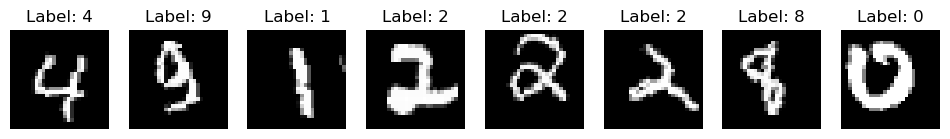

In [7]:
# 建立一個 DataLoader 來展示
vis_loader = DataLoader(augmented_dataset, batch_size=8, shuffle=True)
images, labels = next(iter(vis_loader))

# 視覺化
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    ax = axes[i]
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')
plt.show()

In [8]:
import torchvision.models as models

# --- 步驟 7: 載入預訓練模型 ---

# 載入一個在 ImageNet 上預訓練好的 ResNet-18 模型
# weights=models.ResNet18_Weights.IMAGENET1K_V1 是目前官方建議的用法，
# 它能確保我們載入的是最新、最正確的預訓練權重。
model_resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# 印出這個龐大模型的內部結構
print(model_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  